In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored
import numpy as np
import scipy.stats
from functools import partial
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

In [2]:
import sys
from pathlib import Path
from joblib import Parallel, delayed
import json

In [3]:
def mean_confidence_interval(data, confidence=0.95):
    """Calculate mean, and lower and upper bound of confidence interval"""
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [4]:
def Dxy(event_observed, cve_lifetime, predicted_scores):
    """Calculate Dxy

    Rescale values from 0<=x<=1 range, where 0 is perfect anti-concordance,
    and 0.5 is the expected result from random predictions,
    to the -1<=x<=1 range
    """
    #return 2 * concordance_index_censored(event_observed, cve_lifetime, predicted_scores)[0] - 1
    return 2 * concordance_index(cve_lifetime, predicted_scores, event_observed) - 1

In [5]:
def bootstrap_dxy_inner(df):
    """Bootstrapped Dxy calculation, randomly sampled with replacement

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to sample to compute Dxy from concordance index.
        Assumes that first 3 columns in this dataframe are:

        1. boolean column denoting which events were observed (un-censored)
        2. column with event times, in this case CVE lifetime (time to fix)
        3. column with predicted score, assumed to be category number,
           ordered in such way that larger values predict shorter lifetime

        Other columns are not used.

    Returns
    -------
    float
        Coefficient of concordance correlation, a number between –1 and 1 that
        measures the strength and direction of the relationship between
        predicted score (risk factor) and event time (CVE survival lifetime).
    """
    e, y, x = df.columns
    sample = df.sample(n=df.shape[0], replace=True)

    # calculate Dxy from sample
    return Dxy(sample[e], sample[y], sample[x])


def bootstrap_dxy(df, n=5):
    """Boostrap and calculate Dxy, resampling `n` times"""
    # resample n times
    result = Parallel(n_jobs=-1)(delayed(bootstrap_dxy_inner)(df) for _ in range(n))

    return result

In [327]:
def apply_stats_for_each_value(params, df, fmap, condition_names=None, df_mask=None):
    """Apply stats to each value in column"""

    all_count = df.shape[0]

    if df_mask is not None:
        df = df[df_mask]

    dff = pd.DataFrame({'E': df['E'], 'Y': df['Y'], 'agg': df.apply(fmap, axis=1)}).dropna()
    selected_count = dff.shape[0]
    print(f"all = {all_count}, selected = {selected_count}, uncensored = {dff['E'].sum()}",
               file=sys.stderr)

    # DEBUG
    #print(dff.head())

    stats = dff['Y'].aggregate(['count', 'median'])

    print(f"Computing {params['bootstrap_samples']} × bootstrap Dxy " +
          f"for {dff.shape[0]} elements...", file=sys.stderr)
    dxy_bootstrapped = bootstrap_dxy(dff[['E', 'Y', 'agg']], params['bootstrap_samples'])
    # DEBUG
    #print(dxy_bootstrapped)
    # confidence interval
    print(f"Computing confidence interval from {len(dxy_bootstrapped)} samples...", file=sys.stderr)
    dxy, ci_low, ci_high = mean_confidence_interval(dxy_bootstrapped, confidence=params['confidence'])

    ret = {
        'Cohort': all_count,
        'Number of patients': stats['count'],
        '% of cohort': 100.0*selected_count / all_count,
        'Survival days, median': stats['median'],
        'Survival years, median': stats['median'] / 365,
        'Dxy (full)': Dxy(dff['E'], dff['Y'], dff['agg']),
        'bootstrap': {
            'Dxy': dxy,
            'Confidence interval low': ci_low,
            'Confidence interval high': ci_high,
            'confidence threshold %': 100.0*params['confidence'],
            'bootstrap samples': params['bootstrap_samples'],
        },
    }

    print("Computing descriptive statistics like mean, median, etc....", file=sys.stderr)
    dff_groupby_y = dff.groupby(by=['agg'])['Y']
    groups = dff_groupby_y\
        .agg(['count', 'median', 'min',
              lambda x: np.percentile(x, q=25), lambda x: np.percentile(x, q=75),
              'max', 'mean', 'std', 'skew'])\
        .rename(columns={'<lambda_0>': '25%', '<lambda_1>': '75%'})
    groups['% of cohort'] = 100.0*groups['count']/all_count
    groups['% of selected'] = 100.0*groups['count']/selected_count
    groups['% of patients'] = 100.0*groups['count']/stats['count']
    groups['IR'] = groups['75%'] - groups['25%']

    # DEBUG
    #print(dff_groupby_y.describe())

    groups.index.names = [ params['risk_column_name'] ]
    if condition_names:
        groups.index = groups.index.map(condition_names)

    return ret, groups, dff

In [7]:
def plot_survival_function(params, dff, condition_names=None):
    """Create plot of survival function

    Parameters
    ----------
    params : dict
        Uses params['cve_survival_analysis']['risk_column_name'] and
        params['description'] to create plot titles
    plot_path : str | pathlib.Path
        Where to save the plot
    dff : pandas.DataFrame
        The dataframe with data to compute survival function from
    condition_names : dict | None
        Mapping from risk factor score to risk factor name
    """
    values_list = dff["agg"].unique()
    if condition_names is not None:
        values_list = condition_names.keys()
    print(f"values_list = {values_list}")
    for value in values_list:
        mask = (dff["agg"] == value)  # it's a boolean-valued pd.Series
        time_cell, survival_prob_cell = kaplan_meier_estimator(dff["E"][mask], dff["Y"][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label=f"{condition_names[value]} (n = {mask.sum():d})"
                       if condition_names else
                       f"{value:d} (n = {mask.sum():d})"
                 )

    if 'risk_column_name' in params:
        plt.suptitle(f"Risk factor: '{params['risk_column_name']}'")
    if 'description' in params:
        plt.title(params['description'])
    plt.ylabel("est. probability of survival $\\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.show()
    # plt.savefig(plot_path)
    plt.clf()

In [8]:
def create_values_ranking_list(column_s, column_dtype):
    # if column_dtype is ordered category, we can use the order;
    # or column_dtype is unordered category with two values, any order is good;
    # or column_dtype is some kind of integer, we can use values

    # or column_dtype == 'category'
    if isinstance(column_dtype, pd.CategoricalDtype):
        if column_dtype.ordered:
            # we can use category ordering as ranking
            return column_dtype.categories.to_list()
        if column_dtype.categories.shape[0] == 2:
            # any order is good, we can get correlation or anti-correlation
            return column_dtype.categories.to_list()

    if pd.api.types.is_string_dtype(column_dtype) \
            and column_s.nunique(dropna=True) == 2:
        return column_s.unique().tolist()

    # we can't create ranking list of values
    return None

In [9]:
def values_ranking_hashes(values_ranking_list):
    values_ranking_hash = { value: idx
                            for (idx, value) in enumerate(values_ranking_list) }
    rankings_condition_names = { idx: value
                                 for (idx, value) in enumerate(values_ranking_list) }

    return values_ranking_hash, rankings_condition_names

In [10]:
def f_map_int(row, column_name, min_value=None, max_value=None):
    value = int(row[column_name])
    if min_value is not None and value < min_value:
        return None
    if max_value is not None and value > max_value:
        return None

    return value


def f_map_bool(row, column_name):
    value = bool(row[column_name])
    return value


def f_map_generic(row, column_name, values_ranking_hash):
    value = row[column_name]
    if value in values_ranking_hash:
        return values_ranking_hash[value]

    return None

In [11]:
def uniquify(param):
    seen = set()
    uniq = []
    for elem in param:
        if elem not in seen:
            uniq.append(elem)
            seen.add(elem)

    return uniq

In [12]:
def read_df(input_df):
    print(f"Reading input dataframe from '{input_df}'...")
    df = pd.read_parquet(input_df)
    print(f"{df.shape[0]} elems")
    df = df.drop_duplicates()
    print(f"{df.shape[0]} width duplicates dropped")
    return df

## Read data

In [500]:
DATA_PREFIX="~jnareb/echoes_of_vulnerabilities_code/data/"

In [501]:
#df = read_df(DATA_PREFIX + "cve_survival_input_df")
df = read_df(DATA_PREFIX + "cve_survival_input_most_used_language_df")

Reading input dataframe from '~jnareb/echoes_of_vulnerabilities_code/data/cve_survival_input_most_used_language_df'...
97747 elems
97747 width duplicates dropped


In [502]:
df.head()

,commits,commit_cves,project_names,used_dep_manager,cve_lifespan_commiter_time,cve_lifespan_author_time,embargo_min,embargo_max,lang_Shell,other_languages,...,LatestCommitDate,NumActiveMon,NumAuthors,NumCore,CommunitySize,NumCommits,NumBlobs,NumFiles,NumForks,NumStars
0,1,CVE-2011-1079,0-artnoc_sm-a307fn,0,3497 days 01:37:41,2978 days 21:29:59,False,False,0.0,0.0,...,2020-10-30 00:34:41+00:00,66,1621,655,2,5233,64451,59744,1,<NA>
1,2,CVE-2011-1079,150balbes_Amlogic_s905-kernel,0,3069 days 09:26:00,2978 days 21:29:59,False,False,0.0,0.0,...,2021-07-05 09:53:03+00:00,54,2498,776,60,17607,433579,136904,93,123
2,1,CVE-2011-1079,84506232_sm-g9750_graingripper,0,3098 days 12:25:02,2978 days 21:29:59,False,False,0.0,0.0,...,2019-11-13 00:24:16+00:00,37,1721,691,3,5964,72923,65607,2,1
3,1,CVE-2011-1079,Ante0_CarbonKernel,0,2958 days 16:10:21,2978 days 21:29:59,False,False,0.0,0.0,...,2019-05-22 16:39:21+00:00,38,1277,536,1,3940,66416,61845,0,<NA>
4,2,CVE-2011-1079,Backup-Gits_Eureka-Kernel-Exynos7885-Q-R,0,3751 days 10:01:38,2978 days 21:29:59,False,False,0.0,0.0,...,2021-07-11 12:23:58+00:00,75,1946,723,1,13242,68725,61715,0,<NA>


In [503]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97747 entries, 0 to 97746
Data columns (total 46 columns):
 #   Column                                Non-Null Count  Dtype              
---  ------                                --------------  -----              
 0   commits                               97747 non-null  int64              
 1   commit_cves                           97747 non-null  object             
 2   project_names                         97747 non-null  object             
 3   used_dep_manager                      97747 non-null  int64              
 4   cve_lifespan_commiter_time            97747 non-null  timedelta64[ns]    
 5   cve_lifespan_author_time              97747 non-null  timedelta64[ns]    
 6   embargo_min                           97747 non-null  bool               
 7   embargo_max                           97747 non-null  bool               
 8   lang_Shell                            97747 non-null  float64            
 9   other_languages  

In [504]:
True < False

False

In [505]:
(df['embargo_min'] < df['embargo_max']).value_counts()

False    97747
dtype: int64

Project metadata columns to analyze
- [x] CommitDateRange \[days] = (LatestCommitDate - EarliestCommitDate).dt.days
- [x] NumActiveMon
    - [x] NumActiveMon \[%]
- [x] NumAuthors
    - [x] NumCore / NumAuthors
- [x] NumCore
- [x] NumCommits
- [x] NumStars
- [x] NumForks
- [x] CommunitySize
- [x] NumFiles
- [x] NumBlobs

In [506]:
df.describe()

,commits,used_dep_manager,cve_lifespan_commiter_time,cve_lifespan_author_time,lang_Shell,other_languages,most_common_language_number_of_files,programming_paradigm,compilation_class,type_class,...,cvss,NumActiveMon,NumAuthors,NumCore,CommunitySize,NumCommits,NumBlobs,NumFiles,NumForks,NumStars
count,97747.000000,97747.000000,97747,97747,97747.000000,97747.000000,97747.000000,97747.000000,97747.000000,97747.000000,...,97408.000000,97747.000000,96989.000000,96989.000000,97739.000000,9.754800e+04,9.774700e+04,9.774700e+04,97739.000000,71125.000000
mean,5.131370,0.091010,569 days 12:15:14.104136192,508 days 01:10:43.362916504,27.577215,550.704410,697.357351,1.178931,1.489130,1.479646,...,5.905945,131.199628,5535.744486,265.390178,6350.670950,1.787815e+06,1.198616e+06,5.255018e+05,10991.043882,16564.959972
std,29.965625,0.749142,1065 days 00:37:52.891798944,952 days 19:25:26.467939360,150.017086,3643.865682,5962.393441,0.566677,0.499884,0.499588,...,1.913505,111.975451,21014.545084,768.812445,22808.681054,7.052023e+06,4.005463e+06,1.695992e+06,45501.244094,49107.892685
min,1.000000,0.000000,0 days 00:00:00,0 days 00:00:00,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,1.000000
25%,1.000000,0.000000,17 days 20:54:23,11 days 02:02:03,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,4.600000,37.000000,15.000000,3.000000,1.000000,3.620000e+02,3.842000e+03,1.552000e+03,0.000000,4.000000
50%,1.000000,0.000000,142 days 11:27:36,95 days 01:48:02,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,...,5.600000,98.000000,203.000000,18.000000,6.000000,1.000300e+04,7.283400e+04,4.266600e+04,5.000000,119.000000
75%,3.000000,0.000000,565 days 06:42:21.500000,485 days 18:09:29,0.000000,2.000000,12.000000,1.000000,2.000000,2.000000,...,7.500000,223.000000,1721.000000,210.000000,643.000000,1.404250e+05,5.011510e+05,1.825950e+05,643.000000,2902.000000
max,2349.000000,51.000000,8019 days 14:41:17,8019 days 14:41:17,11867.000000,153573.000000,616542.000000,3.000000,2.000000,2.000000,...,10.000000,698.000000,109725.000000,16920.000000,154323.000000,3.646839e+07,3.604579e+07,4.307279e+07,237104.000000,285958.000000


## Analyze

In [507]:
df['E'] = True
df['Y']=df['cve_lifespan_commiter_time'].dt.days

In [508]:
df[['Y','E']].describe()

,Y
count,97747.000000
mean,569.044810
std,1065.012619
min,0.000000
25%,17.000000
50%,142.000000
75%,565.000000
max,8019.000000


Limit to lifetime $\le$ 365 days

In [509]:
df_full=df
df=df[df['Y'] <= 365]
#df

In [510]:
df[['Y','E']].describe()

,Y
count,62866.000000
mean,79.680225
std,97.347788
min,0.000000
25%,6.000000
50%,34.000000
75%,124.000000
max,365.000000


In [511]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62866 entries, 43 to 97745
Data columns (total 48 columns):
 #   Column                                Non-Null Count  Dtype              
---  ------                                --------------  -----              
 0   commits                               62866 non-null  int64              
 1   commit_cves                           62866 non-null  object             
 2   project_names                         62866 non-null  object             
 3   used_dep_manager                      62866 non-null  int64              
 4   cve_lifespan_commiter_time            62866 non-null  timedelta64[ns]    
 5   cve_lifespan_author_time              62866 non-null  timedelta64[ns]    
 6   embargo_min                           62866 non-null  bool               
 7   embargo_max                           62866 non-null  bool               
 8   lang_Shell                            62866 non-null  float64            
 9   other_languages 

In [512]:
results_summary={}

### NumCore and NumAuthors

**NumCore**

<AxesSubplot: ylabel='Count'>

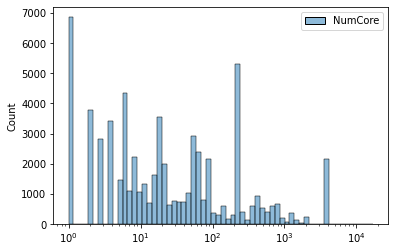

In [513]:
sns.histplot(data=df[['NumCore']].dropna(),log_scale=True)

/tmp/ipykernel_3832658/3356652188.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NumCore_cut'] = numcore_cut


NumCore_cut
[1.0, 2.0)          6865
[2.0, 10.0)        19117
[10.0, 100.0)      22557
[100.0, 1000.0)    11240
[1000.0, inf)       3034
dtype: int64

CategoricalDtype(categories=[[1.0, 2.0), [2.0, 10.0), [10.0, 100.0), [100.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCore_cut', ylabel='CVE+project'>

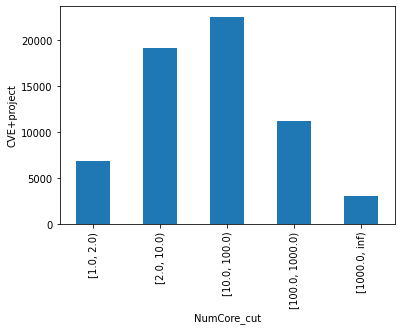

In [514]:
numcore_cut = pd.cut(df['NumCore'].dropna(),
                     bins=[1,2,10,100,1000,np.inf],right=False,include_lowest=True)
df['NumCore_cut'] = numcore_cut
display(df.value_counts('NumCore_cut').sort_index())
display(numcore_cut.dtype)

df.value_counts('NumCore_cut').sort_index().plot.bar(ylabel='CVE+project')

In [515]:
column_name='NumCore'
column_cut='NumCore_cut'
ranking_list = create_values_ranking_list(df['NumCore_cut'], df['NumCore_cut'].dtype)
ranking_list

[Interval(1.0, 2.0, closed='left'),
 Interval(2.0, 10.0, closed='left'),
 Interval(10.0, 100.0, closed='left'),
 Interval(100.0, 1000.0, closed='left'),
 Interval(1000.0, inf, closed='left')]

In [516]:
(values_hash, values_names) = values_ranking_hashes(ranking_list)

In [517]:
f_map = lambda row: f_map_generic(row, 'NumCore_cut', values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': 'NumCore_cut',
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

all = 62866, selected = 62813, uncensored = 62813
Computing 50 × bootstrap Dxy for 62813 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 62866,
    "Number of patients": 62813.0,
    "% of cohort": 99.91569369770623,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.12396463985078343,
    "bootstrap": {
        "Dxy": 0.1241630813612813,
        "Confidence interval low": 0.12348889121882521,
        "Confidence interval high": 0.1248372715037374,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
NumCore_cut,,,,,,,,,,,,,
"[1.0, 2.0)",6865,31.0,0,6.0,111.0,365,75.480117,95.185137,1.431111,10.920052,10.929266,10.929266,105.0
"[2.0, 10.0)",19117,18.0,0,2.0,85.0,365,61.429356,88.111172,1.688703,30.409124,30.434783,30.434783,83.0
"[10.0, 100.0)",22557,30.0,0,5.0,105.0,365,70.990602,90.692834,1.511993,35.881080,35.911356,35.911356,100.0
"[100.0, 1000.0)",11240,92.0,0,25.0,209.0,365,123.118327,108.829373,0.608950,17.879299,17.894385,17.894385,184.0
"[1000.0, inf)",3034,69.0,0,18.0,183.0,365,108.087343,106.166542,0.845891,4.826138,4.830210,4.830210,165.0


In [518]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

values_list = dict_keys([0, 1, 2, 3, 4])


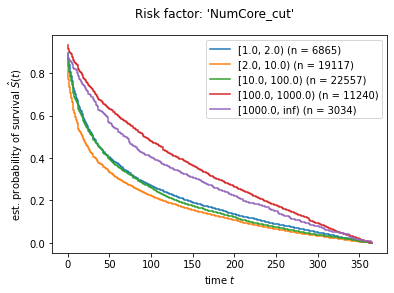

<Figure size 432x288 with 0 Axes>

In [519]:
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='Y', ylabel='NumCore_cut'>

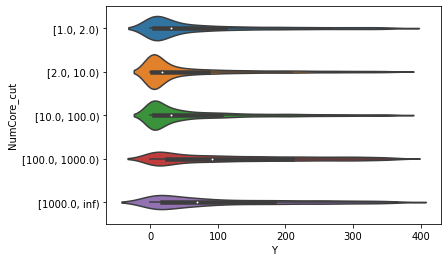

In [520]:
sns.violinplot(data=df, x="Y", y="NumCore_cut")

----

/tmp/ipykernel_3832658/180084078.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NumCore_cut2'] = numcore_cut


NumCore_cut2
[10.0, inf)    36831
[1.0, 10.0)    25982
dtype: int64

CategoricalDtype(categories=[[1.0, 10.0), [10.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCore_cut2', ylabel='CVE+project'>

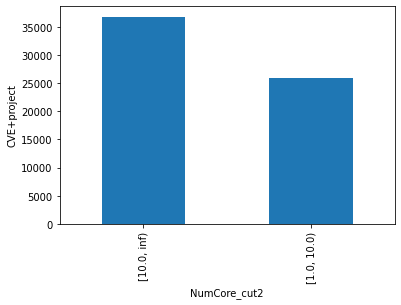

In [521]:
numcore_cut = pd.cut(df['NumCore'].dropna(),
                     bins=[1,10,np.inf],right=False,include_lowest=True)
df['NumCore_cut2'] = numcore_cut
display(df.value_counts('NumCore_cut2'))
display(numcore_cut.dtype)

df.value_counts('NumCore_cut2').plot.bar(ylabel='CVE+project')

In [522]:
ranking_list = create_values_ranking_list(df['NumCore_cut2'], df['NumCore_cut2'].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

In [523]:
f_map = lambda row: f_map_generic(row, 'NumCore_cut2', values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': 'NumCore_cut2',
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

all = 62866, selected = 62813, uncensored = 62813
Computing 50 × bootstrap Dxy for 62813 elements...


{
    "Cohort": 62866,
    "Number of patients": 62813.0,
    "% of cohort": 99.91569369770623,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.08600375912162272,
    "bootstrap": {
        "Dxy": 0.08590896210684736,
        "Confidence interval low": 0.08529881372631182,
        "Confidence interval high": 0.0865191104873829,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
NumCore_cut2,,,,,,,,,,,,,
"[1.0, 10.0)",25982,21.0,0,3.0,92.0,365,65.141867,90.245350,1.614717,41.329176,41.364049,41.364049,89.0
"[10.0, inf)",36831,47.0,0,9.0,147.0,365,89.954712,100.811009,1.117080,58.586517,58.635951,58.635951,138.0


In [524]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

values_list = dict_keys([0, 1])


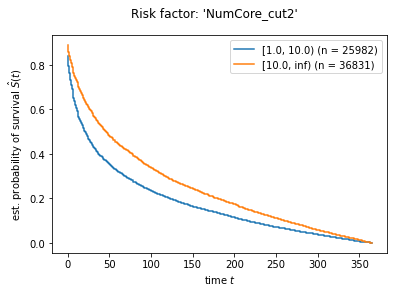

<Figure size 432x288 with 0 Axes>

In [525]:
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='Y', ylabel='NumCore_cut2'>

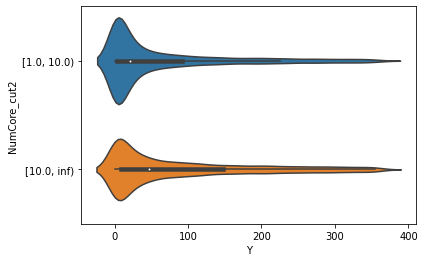

In [526]:
sns.violinplot(data=df, x="Y", y="NumCore_cut2")

<AxesSubplot: xlabel='NumCore', ylabel='Y'>

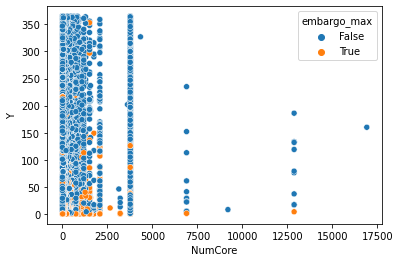

In [527]:
sns.scatterplot(data=df, x='NumCore', y='Y', hue='embargo_max')

-----
**NumAuthors**

<AxesSubplot: ylabel='Count'>

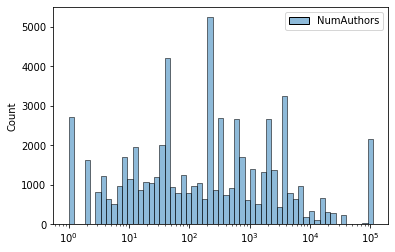

In [528]:
sns.histplot(data=df[['NumAuthors']].dropna(),log_scale=True)

/tmp/ipykernel_3832658/3339898687.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumAuthors_cut
[1.0, 4.0)          5132
[4.0, 6.0)          1832
[6.0, 100.0)       20134
[100.0, 1000.0)    18035
[1000.0, inf)      17680
dtype: int64

CategoricalDtype(categories=[[1.0, 4.0), [4.0, 6.0), [6.0, 100.0), [100.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumAuthors_cut', ylabel='CVE+project'>

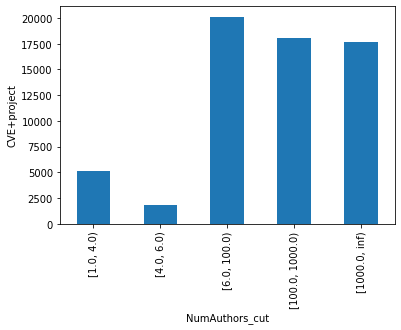

In [529]:
column_name = 'NumAuthors'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,4,6,100,1e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [530]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(1.0, 4.0, closed='left'),
 1: Interval(4.0, 6.0, closed='left'),
 2: Interval(6.0, 100.0, closed='left'),
 3: Interval(100.0, 1000.0, closed='left'),
 4: Interval(1000.0, inf, closed='left')}

In [531]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62813, uncensored = 62813
Computing 50 × bootstrap Dxy for 62813 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62813.0,
    "% of cohort": 99.91569369770623,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.09038010516190864,
    "bootstrap": {
        "Dxy": 0.09076627866873864,
        "Confidence interval low": 0.08991296510922771,
        "Confidence interval high": 0.09161959222824957,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
NumAuthors_cut,,,,,,,,,,,,,
"[1.0, 4.0)",5132,38.0,0,7.0,136.0,365,84.029423,98.919030,1.226251,8.163395,8.170283,8.170283,129.0
"[4.0, 6.0)",1832,55.0,0,11.0,168.0,365,98.624454,103.639519,0.975107,2.914135,2.916594,2.916594,157.0
"[6.0, 100.0)",20134,19.0,0,2.0,85.0,365,61.874789,88.082815,1.696369,32.026851,32.053874,32.053874,83.0
"[100.0, 1000.0)",18035,28.0,0,5.0,105.0,365,69.926754,90.199154,1.528197,28.688003,28.712209,28.712209,100.0
"[1000.0, inf)",17680,68.0,0,15.0,182.0,365,106.719627,106.546102,0.840387,28.123310,28.147040,28.147040,167.0


In [532]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

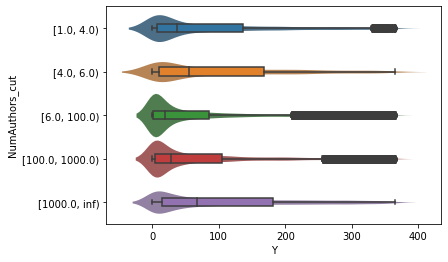

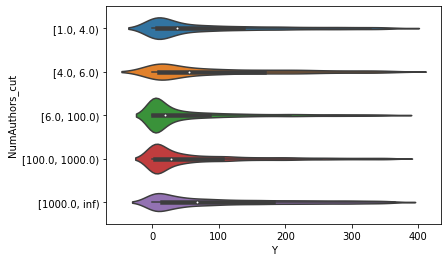

In [533]:
ax = sns.violinplot(data=df, x="Y", y=column_cut,
                    inner=None, width=1.0, linewidth=0, saturation=0.4)
sns.boxplot(data=df, x="Y", y=column_cut,
            width=0.2, boxprops={'zorder': 2}, ax=ax)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

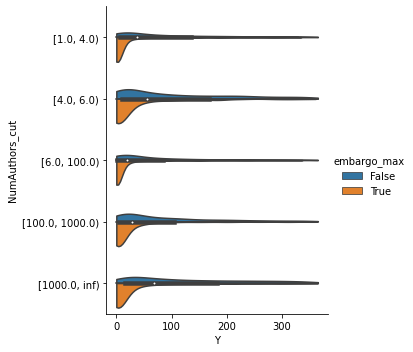

In [534]:
sns.catplot(
    data=df, x="Y", y="NumAuthors_cut", hue="embargo_max",
    kind="violin", bw=.25, cut=0, split=True,
)

{0: Interval(1.0, 4.0, closed='left'), 1: Interval(4.0, 6.0, closed='left'), 2: Interval(6.0, 100.0, closed='left'), 3: Interval(100.0, 1000.0, closed='left'), 4: Interval(1000.0, inf, closed='left')}
dict_keys([0, 1, 2, 3, 4])
values_list = dict_keys([0, 1, 2, 3, 4])


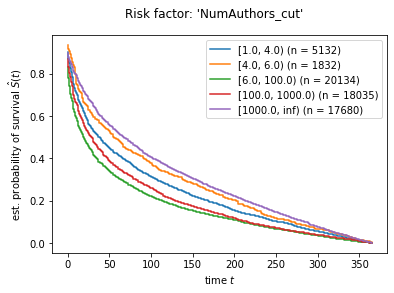

<Figure size 432x288 with 0 Axes>

In [535]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='NumAuthors', ylabel='Y'>

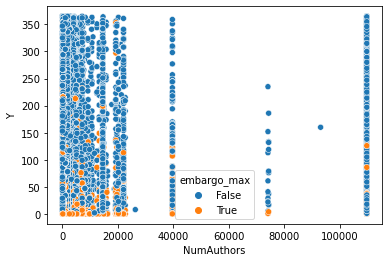

In [536]:
sns.scatterplot(data=df, x='NumAuthors', y='Y', hue='embargo_max')

### NumCore / NumAuthors

<AxesSubplot: xlabel='NumAuthors', ylabel='NumCore'>

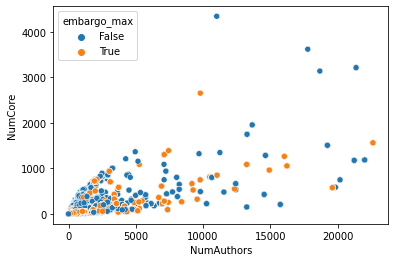

In [537]:
sns.scatterplot(data=df[df['NumAuthors']<25000], x='NumAuthors', y='NumCore', hue='embargo_max')

<AxesSubplot: xlabel='NumAuthors', ylabel='NumCore'>

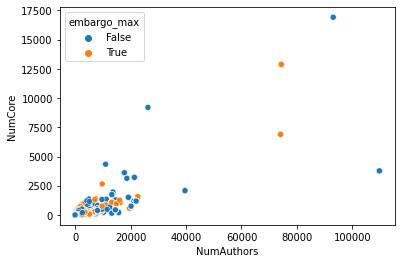

In [538]:
sns.scatterplot(data=df, x='NumAuthors', y='NumCore', hue='embargo_max')

In [539]:
df['NumCore/NumAuthors'] = df['NumCore'] / df['NumAuthors']
df['NumCore/NumAuthors'].describe()

/tmp/ipykernel_3832658/998512510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NumCore/NumAuthors'] = df['NumCore'] / df['NumAuthors']


count    62813.000000
mean         0.207294
std          0.235437
min          0.003810
25%          0.053170
50%          0.111111
75%          0.257732
max          1.000000
Name: NumCore/NumAuthors, dtype: float64

In [540]:
df['NumCore/NumAuthors'][df['NumAuthors'] > 4].describe()

count    56476.000000
mean         0.148022
std          0.133745
min          0.003810
25%          0.053170
50%          0.104918
75%          0.187500
max          0.875000
Name: NumCore/NumAuthors, dtype: float64

<AxesSubplot: ylabel='Count'>

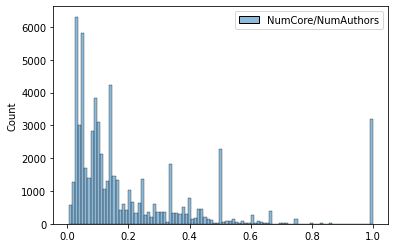

In [541]:
sns.histplot(data=df[['NumCore/NumAuthors']].dropna())

<AxesSubplot: ylabel='Count'>

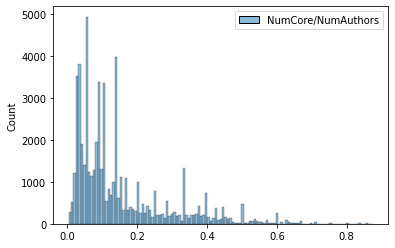

In [542]:
sns.histplot(data=df[['NumCore/NumAuthors']][df['NumAuthors']>4].dropna())

/tmp/ipykernel_3832658/3641574535.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumCore/NumAuthors cut
[0.0, 0.333)      49470
[0.333, 0.667)     9508
[0.667, 1.001)     3835
dtype: int64

CategoricalDtype(categories=[[0.0, 0.333), [0.333, 0.667), [0.667, 1.001)], ordered=True)

<AxesSubplot: xlabel='NumCore/NumAuthors cut', ylabel='CVE+project'>

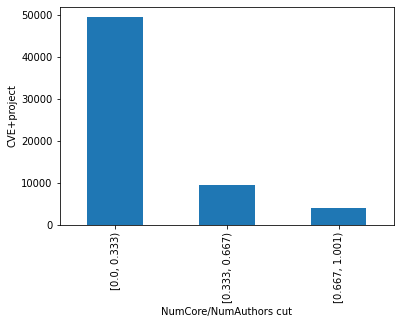

In [543]:
column_name = 'NumCore/NumAuthors'
column_cut = column_name + ' cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,1.0/3.0,2.0/3.0,1.001],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [544]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(0.0, 0.333, closed='left'),
 1: Interval(0.333, 0.667, closed='left'),
 2: Interval(0.667, 1.001, closed='left')}

In [545]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62813, uncensored = 62813
Computing 50 × bootstrap Dxy for 62813 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 62866,
    "Number of patients": 62813.0,
    "% of cohort": 99.91569369770623,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.052208379907902724,
    "bootstrap": {
        "Dxy": 0.052323907981284126,
        "Confidence interval low": 0.05182714965746837,
        "Confidence interval high": 0.052820666305099885,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
NumCore/NumAuthors cut,,,,,,,,,,,,,
"[0.0, 0.333)",49470,30.0,0,4.0,112.0,365,74.290418,94.340897,1.411986,78.691184,78.757582,78.757582,108.0
"[0.333, 0.667)",9508,68.0,0,13.0,186.0,365,107.461191,107.176217,0.815713,15.124232,15.136994,15.136994,173.0
"[0.667, 1.001)",3835,34.0,0,7.0,127.0,365,80.508475,98.245403,1.317157,6.100277,6.105424,6.105424,120.0


In [546]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

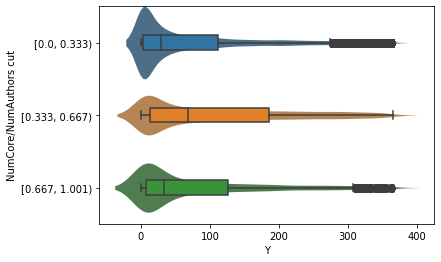

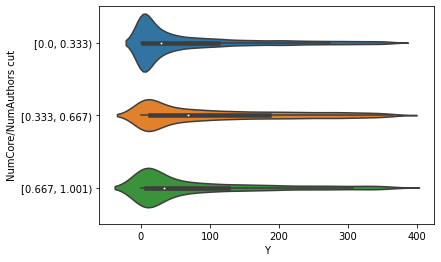

In [547]:
ax = sns.violinplot(data=df, x="Y", y=column_cut,
                    inner=None, width=1.0, linewidth=0, saturation=0.4)
sns.boxplot(data=df, x="Y", y=column_cut,
            width=0.2, boxprops={'zorder': 2}, ax=ax)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

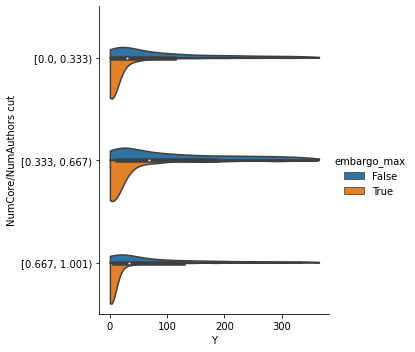

In [548]:
sns.catplot(
    data=df, x="Y", y=column_cut, hue="embargo_max",
    kind="violin", bw=.25, cut=0, split=True,
)

{0: Interval(0.0, 0.333, closed='left'), 1: Interval(0.333, 0.667, closed='left'), 2: Interval(0.667, 1.001, closed='left')}
dict_keys([0, 1, 2])
values_list = dict_keys([0, 1, 2])


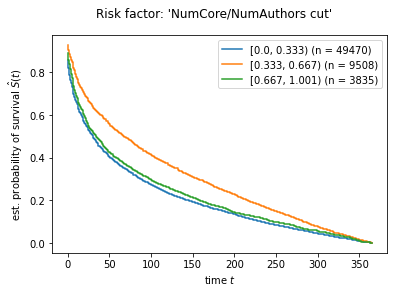

<Figure size 432x288 with 0 Axes>

In [549]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='Y', ylabel='NumCore/NumAuthors'>

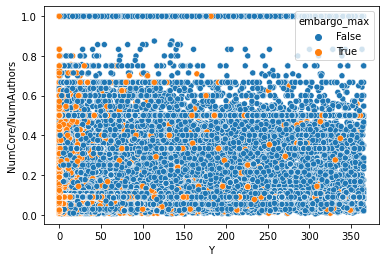

In [550]:
sns.scatterplot(data=df, y=column_name, x='Y', hue='embargo_max')

<AxesSubplot: xlabel='Y', ylabel='NumCore/NumAuthors'>

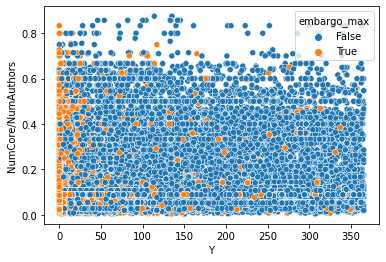

In [551]:
sns.scatterplot(data=df[df['NumAuthors']>4], y=column_name, x='Y', hue='embargo_max')

### NumCommits

<AxesSubplot: ylabel='Count'>

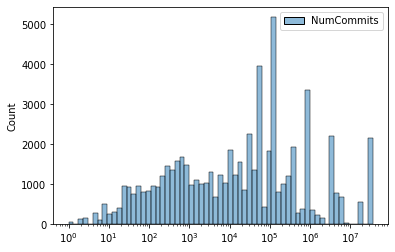

In [552]:
sns.histplot(data=df[['NumCommits']].dropna(), log_scale=True)

/tmp/ipykernel_3832658/1991781596.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumCommits_cut
[1.0, 10.0)               1232
[10.0, 100.0)             5837
[100.0, 1000.0)          10731
[1000.0, 10000.0)         8754
[10000.0, 100000.0)      14850
[100000.0, 1000000.0)    14248
[1000000.0, inf)          7107
dtype: int64

CategoricalDtype(categories=[[1.0, 10.0), [10.0, 100.0), [100.0, 1000.0), [1000.0, 10000.0), [10000.0, 100000.0), [100000.0, 1000000.0), [1000000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCommits_cut', ylabel='CVE+project'>

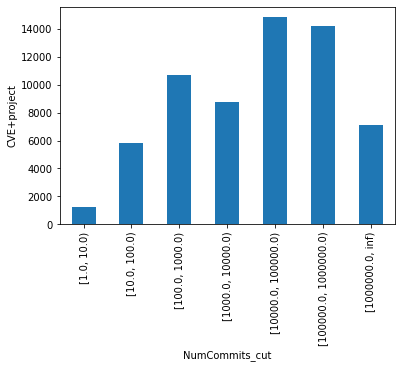

In [553]:
column_name = 'NumCommits'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,10,100,1000,10000,100000,1000000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 62866, selected = 62759, uncensored = 62759
Computing 50 × bootstrap Dxy for 62759 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 62866,
    "Number of patients": 62759.0,
    "% of cohort": 99.82979671046353,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.0011505664254758408,
    "bootstrap": {
        "Dxy": 0.0016774427413063565,
        "Confidence interval low": 0.0009439453978250222,
        "Confidence interval high": 0.0024109400847876906,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
NumCommits_cut,,,,,,,,,,,,,
"[1.0, 10.0)",1232,52.0,0,9.0,163.25,365,98.549513,105.512932,0.945317,1.959724,1.963065,1.963065,154.25
"[10.0, 100.0)",5837,41.0,0,9.0,131.00,365,84.054994,97.823570,1.244068,9.284828,9.300658,9.300658,122.00
"[100.0, 1000.0)",10731,32.0,0,6.0,117.00,365,76.964402,95.577261,1.353958,17.069640,17.098743,17.098743,111.00
"[1000.0, 10000.0)",8754,52.0,0,7.0,167.00,365,95.933859,105.385474,0.971410,13.924856,13.948597,13.948597,160.00
"[10000.0, 100000.0)",14850,19.0,0,2.0,86.00,365,60.390505,85.732778,1.718651,23.621671,23.661945,23.661945,84.00
"[100000.0, 1000000.0)",14248,36.0,0,7.0,129.00,365,82.780250,99.339239,1.262593,22.664079,22.702720,22.702720,122.00
"[1000000.0, inf)",7107,50.0,0,11.0,149.00,365,91.064303,99.875980,1.118998,11.304998,11.324272,11.324272,138.00


values_list = dict_keys([0, 1, 2, 3, 4, 5, 6])


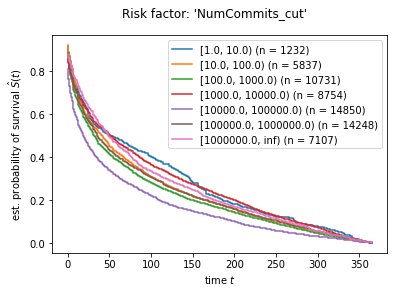

<Figure size 432x288 with 0 Axes>

In [554]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [555]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumCommits_cut'>

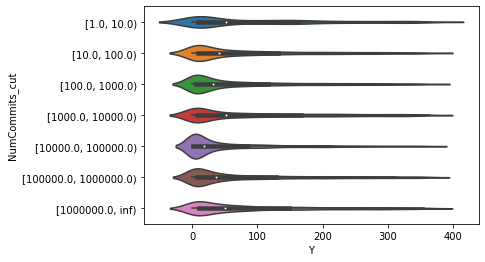

In [556]:
sns.violinplot(data=df, x="Y", y="NumCommits_cut")

/tmp/ipykernel_3832658/436446493.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumCommits_cut2
[1.0, 100.0)          7069
[100.0, 100000.0)    34335
[100000.0, inf)      21355
dtype: int64

CategoricalDtype(categories=[[1.0, 100.0), [100.0, 100000.0), [100000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCommits_cut2', ylabel='CVE+project'>

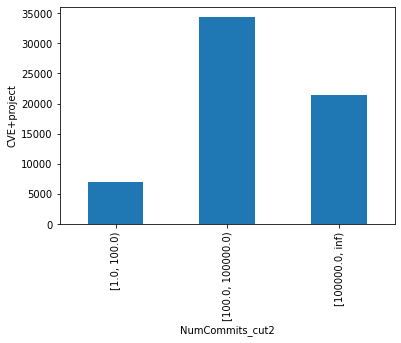

In [557]:
column_name = 'NumCommits'
column_cut = column_name + '_cut2'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,100,100000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 62866, selected = 62759, uncensored = 62759
Computing 50 × bootstrap Dxy for 62759 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62759.0,
    "% of cohort": 99.82979671046353,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.01835295333461784,
    "bootstrap": {
        "Dxy": 0.017520687106581233,
        "Confidence interval low": 0.016768028646902536,
        "Confidence interval high": 0.01827334556625993,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
NumCommits_cut2,,,,,,,,,,,,,
"[1.0, 100.0)",7069,42.0,0,9.0,140.0,365,86.581129,99.351131,1.187677,11.244552,11.263723,11.263723,131.0
"[100.0, 100000.0)",34335,29.0,0,4.0,114.0,365,74.632562,95.237360,1.382066,54.616168,54.709285,54.709285,110.0
"[100000.0, inf)",21355,41.0,0,8.0,136.0,365,85.537204,99.592385,1.212059,33.969077,34.026992,34.026992,128.0


values_list = dict_keys([0, 1, 2])


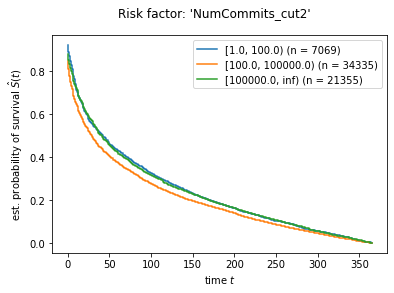

<Figure size 432x288 with 0 Axes>

In [558]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [559]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumCommits_cut2'>

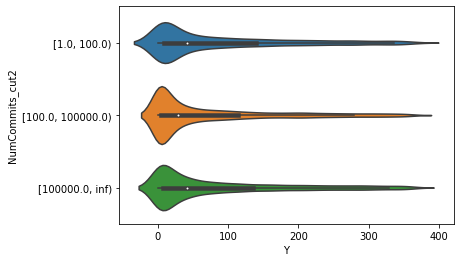

In [560]:
sns.violinplot(data=df, x="Y", y="NumCommits_cut2")

<AxesSubplot: xlabel='NumCommits', ylabel='Y'>

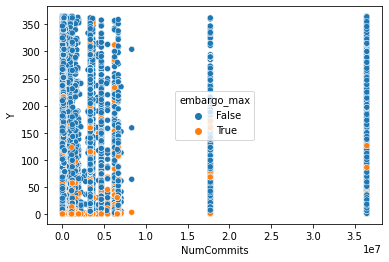

In [561]:
sns.scatterplot(data=df, x='NumCommits', y='Y', hue='embargo_max')

### NumMon and ActiveMon \[%]

In [562]:
df['CommitDateRange']=df['LatestCommitDate']-df['EarliestCommitDate']
df['CommitDateRange [days]']=df['CommitDateRange'].dt.days
df['CommitDateRange [mon]']=\
12 * (df['LatestCommitDate'].dt.year  - df['EarliestCommitDate'].dt.year) +\
     (df['LatestCommitDate'].dt.month - df['EarliestCommitDate'].dt.month)

df[['CommitDateRange [days]', 'CommitDateRange [mon]']].describe()

/tmp/ipykernel_3832658/2436893064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CommitDateRange']=df['LatestCommitDate']-df['EarliestCommitDate']
/tmp/ipykernel_3832658/2436893064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CommitDateRange [days]']=df['CommitDateRange'].dt.days
/tmp/ipykernel_3832658/2436893064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,CommitDateRange [days],CommitDateRange [mon]
count,62866.000000,62866.000000
mean,6738.244584,221.379442
std,7475.956657,245.568813
min,0.000000,0.000000
25%,2382.000000,78.000000
50%,4486.000000,147.000000
75%,8247.000000,271.000000
max,81273.000000,2671.000000


<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='NumActiveMon'>

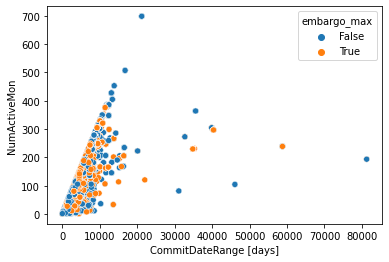

In [563]:
sns.scatterplot(data=df, x='CommitDateRange [days]', y='NumActiveMon', hue='embargo_max')

<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='CommitDateRange [mon]'>

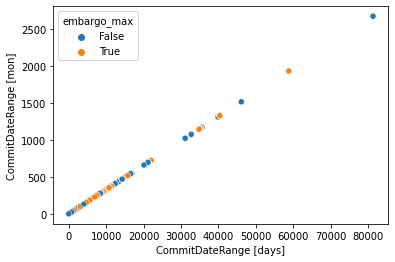

In [564]:
sns.scatterplot(data=df, x='CommitDateRange [days]', y='CommitDateRange [mon]', hue='embargo_max')

In [565]:
df['NumActiveMon [%]']=100.0*df['NumActiveMon']/(df['CommitDateRange [mon]']+1)
df[['NumActiveMon [%]']].describe()

/tmp/ipykernel_3832658/571980132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NumActiveMon [%]']=100.0*df['NumActiveMon']/(df['CommitDateRange [mon]']+1)


,NumActiveMon [%]
count,62866.000000
mean,74.850116
std,27.203203
min,1.379310
25%,50.150150
50%,83.783784
75%,100.000000
max,200.000000


<AxesSubplot: ylabel='Count'>

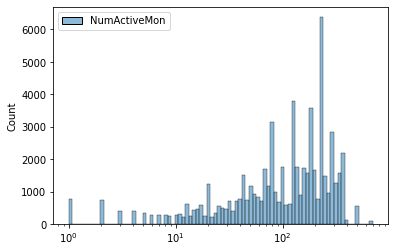

In [566]:
sns.histplot(data=df[['NumActiveMon']].dropna(), log_scale=True)

<AxesSubplot: ylabel='Count'>

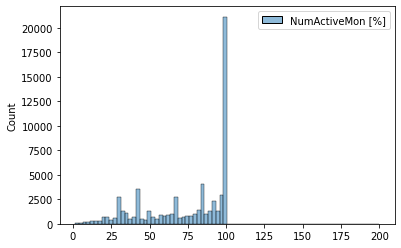

In [567]:
sns.histplot(data=df[['NumActiveMon [%]']].dropna())

/tmp/ipykernel_3832658/3759419786.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumActiveMon [%] cut
[-0.1, 25.0)       3026
[25.0, 50.0)      12414
[50.0, 75.0)       9613
[75.0, 100.0)     20560
[100.0, 200.0)    17252
dtype: int64

CategoricalDtype(categories=[[-0.1, 25.0), [25.0, 50.0), [50.0, 75.0), [75.0, 100.0), [100.0, 200.0)], ordered=True)

<AxesSubplot: xlabel='NumActiveMon [%] cut', ylabel='CVE+project'>

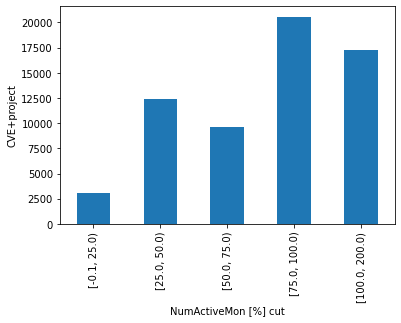

In [568]:
column_name = 'NumActiveMon [%]'
column_cut = column_name + ' cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[-0.1,25,50,75,100,200],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 62866, selected = 62865, uncensored = 62865
Computing 50 × bootstrap Dxy for 62865 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 62866,
    "Number of patients": 62865.0,
    "% of cohort": 99.99840931505106,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.10415993897642772,
    "bootstrap": {
        "Dxy": -0.10406138886864646,
        "Confidence interval low": -0.10487002321313996,
        "Confidence interval high": -0.10325275452415297,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
NumActiveMon [%] cut,,,,,,,,,,,,,
"[-0.1, 25.0)",3026,35.5,0,5.0,138.0,365,84.579643,101.122777,1.198407,4.813413,4.813489,4.813489,133.0
"[25.0, 50.0)",12414,73.0,0,18.0,181.0,365,107.379894,104.268315,0.845125,19.746763,19.747077,19.747077,163.0
"[50.0, 75.0)",9613,31.0,0,4.0,120.0,365,77.293041,96.970449,1.343523,15.291254,15.291498,15.291498,116.0
"[75.0, 100.0)",20560,32.0,0,6.0,123.0,365,78.645623,97.374865,1.312595,32.704483,32.705003,32.705003,117.0
"[100.0, 200.0)",17252,20.0,0,2.0,87.0,365,61.456643,86.517571,1.742999,27.442497,27.442933,27.442933,85.0


values_list = dict_keys([0, 1, 2, 3, 4])


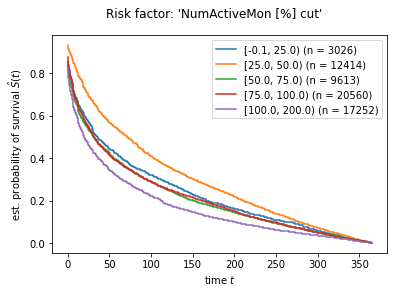

<Figure size 432x288 with 0 Axes>

In [569]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [570]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumActiveMon [%] cut'>

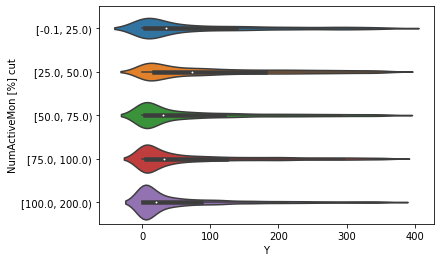

In [571]:
sns.violinplot(data=df, x="Y", y="NumActiveMon [%] cut")

<AxesSubplot: xlabel='NumActiveMon [%]', ylabel='Y'>

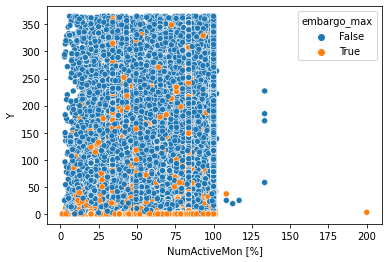

In [572]:
sns.scatterplot(data=df, x='NumActiveMon [%]', y='Y', hue='embargo_max')

/tmp/ipykernel_3832658/3704680564.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumActiveMon_cut
[1, 10)         3805
[10, 100)      23106
[100, 1000)    35955
dtype: int64

CategoricalDtype(categories=[[1, 10), [10, 100), [100, 1000)], ordered=True)

<AxesSubplot: xlabel='NumActiveMon_cut', ylabel='CVE+project'>

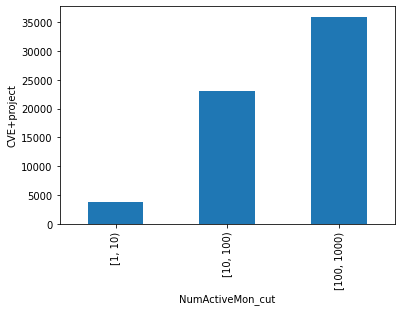

In [573]:
column_name = 'NumActiveMon'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,10,100,1000],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [574]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

print(values_names)

{0: Interval(1, 10, closed='left'), 1: Interval(10, 100, closed='left'), 2: Interval(100, 1000, closed='left')}


all = 62866, selected = 62866, uncensored = 62866
Computing 50 × bootstrap Dxy for 62866 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.07727737172653504,
    "bootstrap": {
        "Dxy": -0.07735890860850216,
        "Confidence interval low": -0.07805137307204518,
        "Confidence interval high": -0.07666644414495913,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
NumActiveMon_cut,,,,,,,,,,,,,
"[1, 10)",3805,48.0,0,8.0,157.0,365,93.807096,103.427645,1.020823,6.052556,6.052556,6.052556,149.0
"[10, 100)",23106,48.0,0,10.0,149.0,365,91.393751,101.262476,1.093133,36.754366,36.754366,36.754366,139.0
"[100, 1000)",35955,27.0,0,3.0,106.0,365,70.657683,93.046345,1.489765,57.193077,57.193077,57.193077,103.0


values_list = dict_keys([0, 1, 2])


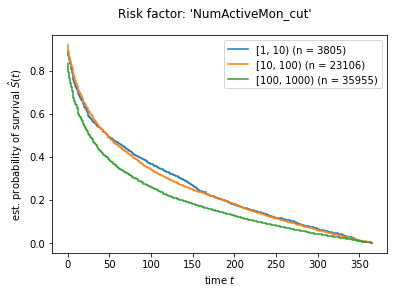

<Figure size 432x288 with 0 Axes>

In [575]:
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [576]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumActiveMon_cut'>

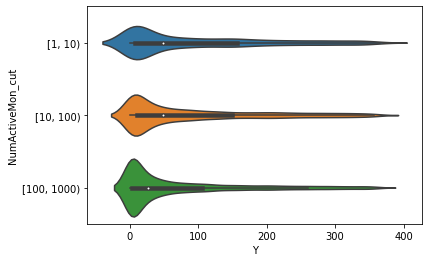

In [577]:
sns.violinplot(data=df, x="Y", y="NumActiveMon_cut")

<AxesSubplot: xlabel='NumActiveMon', ylabel='Y'>

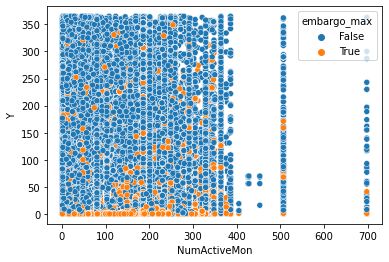

In [578]:
sns.scatterplot(data=df, x='NumActiveMon', y='Y', hue='embargo_max')

-----
**CommitDateRange \[days]**

In [579]:
column_name='CommitDateRange [days]'

In [580]:
df['CommitDateRange [days]'].describe()

count    62866.000000
mean      6738.244584
std       7475.956657
min          0.000000
25%       2382.000000
50%       4486.000000
75%       8247.000000
max      81273.000000
Name: CommitDateRange [days], dtype: float64

<AxesSubplot: ylabel='Count'>

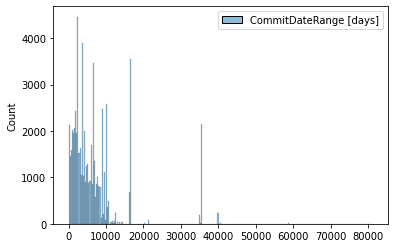

In [581]:
column_name='CommitDateRange [days]'
sns.histplot(data=df[[column_name]].dropna())

<AxesSubplot: ylabel='Count'>

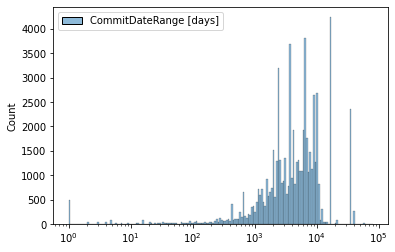

In [582]:
column_name='CommitDateRange [days]'
sns.histplot(data=df[[column_name]].dropna()+1, log_scale=True)

/tmp/ipykernel_3832658/1267421467.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


CommitDateRange [days] cut
[0.0, 30.0)           1007
[30.0, 365.0)         1388
[365.0, 1000.0)       3510
[1000.0, 5000.0)     27464
[5000.0, 10000.0)    18531
[10000.0, inf)       10966
dtype: int64

CategoricalDtype(categories=[[0.0, 30.0), [30.0, 365.0), [365.0, 1000.0), [1000.0, 5000.0), [5000.0, 10000.0), [10000.0, inf)], ordered=True)

<AxesSubplot: xlabel='CommitDateRange [days] cut', ylabel='CVE+project'>

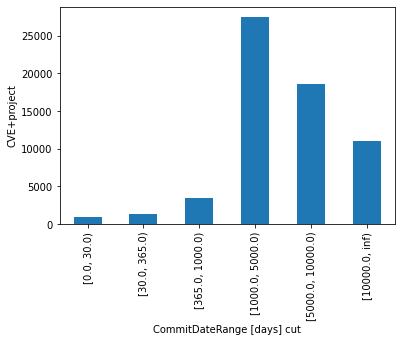

In [583]:
column_name = 'CommitDateRange [days]'
column_cut = column_name + ' cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,30,365,1e3,5e3,1e4,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [584]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(0.0, 30.0, closed='left'),
 1: Interval(30.0, 365.0, closed='left'),
 2: Interval(365.0, 1000.0, closed='left'),
 3: Interval(1000.0, 5000.0, closed='left'),
 4: Interval(5000.0, 10000.0, closed='left'),
 5: Interval(10000.0, inf, closed='left')}

In [585]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62866, uncensored = 62866
Computing 50 × bootstrap Dxy for 62866 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.01681008595722866,
    "bootstrap": {
        "Dxy": 0.016896283406881575,
        "Confidence interval low": 0.016040494150191566,
        "Confidence interval high": 0.017752072663571584,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
CommitDateRange [days] cut,,,,,,,,,,,,,
"[0.0, 30.0)",1007,34.0,0,6.0,148.0,363,90.203575,106.415141,1.109180,1.601820,1.601820,1.601820,142.0
"[30.0, 365.0)",1388,67.0,0,13.0,172.0,365,103.386888,104.893881,0.885082,2.207871,2.207871,2.207871,159.0
"[365.0, 1000.0)",3510,41.0,0,8.0,144.0,365,85.075783,97.983216,1.172362,5.583304,5.583304,5.583304,136.0
"[1000.0, 5000.0)",27464,30.0,0,5.0,114.0,365,75.049483,94.317654,1.391040,43.686571,43.686571,43.686571,109.0
"[5000.0, 10000.0)",18531,27.0,0,3.0,112.0,365,74.093411,97.125288,1.421645,29.476983,29.476983,29.476983,109.0
"[10000.0, inf)",10966,53.0,0,13.0,157.0,365,95.024713,100.865256,1.035126,17.443451,17.443451,17.443451,144.0


In [586]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

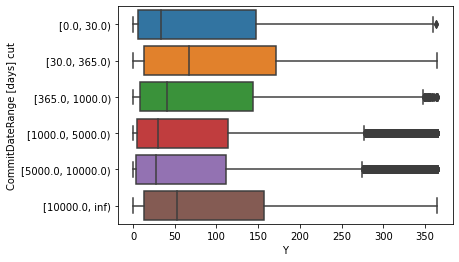

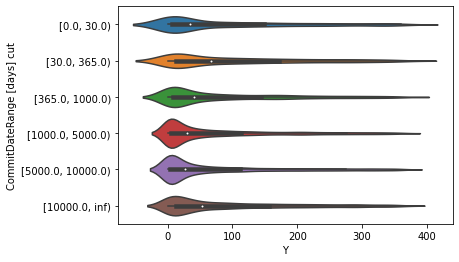

In [587]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

{0: Interval(0.0, 30.0, closed='left'), 1: Interval(30.0, 365.0, closed='left'), 2: Interval(365.0, 1000.0, closed='left'), 3: Interval(1000.0, 5000.0, closed='left'), 4: Interval(5000.0, 10000.0, closed='left'), 5: Interval(10000.0, inf, closed='left')}
dict_keys([0, 1, 2, 3, 4, 5])
values_list = dict_keys([0, 1, 2, 3, 4, 5])


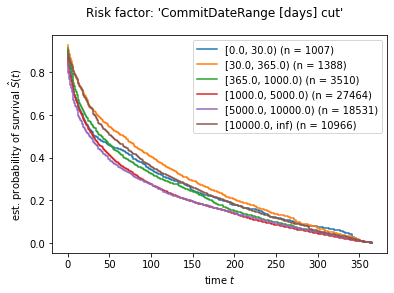

<Figure size 432x288 with 0 Axes>

In [588]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='Y'>

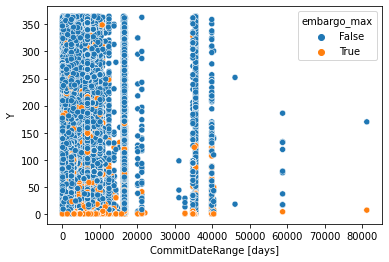

In [589]:
sns.scatterplot(data=df, x=column_name, y='Y', hue='embargo_max')

<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='Y'>

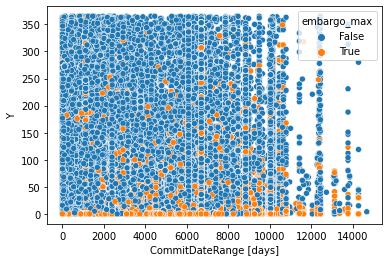

In [590]:
sns.scatterplot(data=df[df[column_name]<15000], x=column_name, y='Y', hue='embargo_max')

### Popularity: NumStars

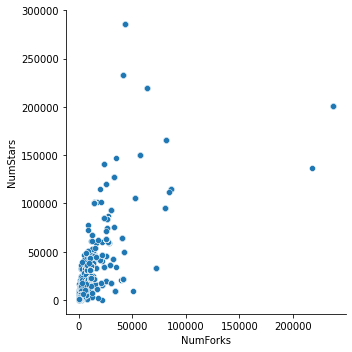

In [591]:
sns.relplot(df[['NumForks','NumStars']].dropna(),x='NumForks',y='NumStars')
plt.show()

<AxesSubplot: ylabel='Count'>

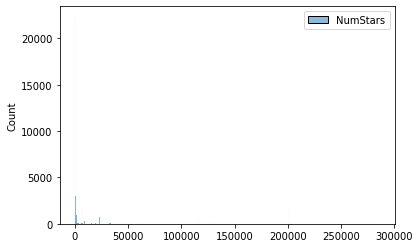

<AxesSubplot: ylabel='Count'>

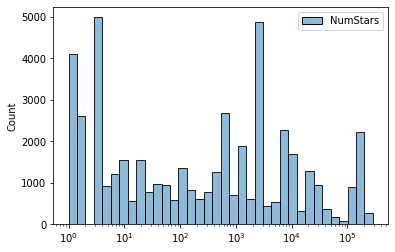

In [592]:
sns.histplot(data=df[['NumStars']].dropna())
plt.show()
sns.histplot(data=df[['NumStars']].dropna(), log_scale=True)
plt.show()

/tmp/ipykernel_3832658/472104740.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumStars_cut
[1.0, 2.0)              4093
[2.0, 5.0)              7612
[5.0, 10.0)             2513
[10.0, 100.0)           6522
[100.0, 1000.0)         8028
[1000.0, 10000.0)      11823
[10000.0, 100000.0)     3685
[100000.0, inf)         3370
dtype: int64

CategoricalDtype(categories=[[1.0, 2.0), [2.0, 5.0), [5.0, 10.0), [10.0, 100.0), [100.0, 1000.0), [1000.0, 10000.0), [10000.0, 100000.0), [100000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumStars_cut', ylabel='CVE+project'>

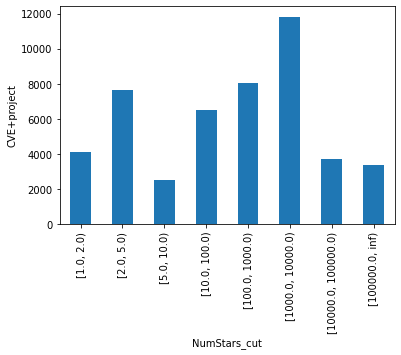

In [593]:
column_name = 'NumStars'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,2,5,10,100,1000,10000,100000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

/tmp/ipykernel_3832658/2701432508.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumStars_cut
[1.0, 3.0)           6710
[3.0, 100.0)        14030
[100.0, 10000.0)    19851
[10000.0, inf)       7055
dtype: int64

CategoricalDtype(categories=[[1.0, 3.0), [3.0, 100.0), [100.0, 10000.0), [10000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumStars_cut', ylabel='CVE+project'>

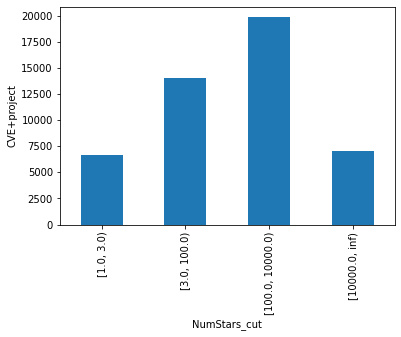

In [594]:
column_name = 'NumStars'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,3,100,10000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 62866, selected = 47646, uncensored = 47646
Computing 50 × bootstrap Dxy for 47646 elements...


{
    "Cohort": 62866,
    "Number of patients": 47646.0,
    "% of cohort": 75.78977507714822,
    "Survival days, median": 40.0,
    "Survival years, median": 0.1095890410958904,
    "Dxy (full)": 0.029234222288123446,
    "bootstrap": {
        "Dxy": 0.02960676968716903,
        "Confidence interval low": 0.028635825735421203,
        "Confidence interval high": 0.03057771363891686,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
NumStars_cut,,,,,,,,,,,,,
"[1.0, 3.0)",6710,41.0,0,5.0,155.0,365,89.867660,104.342922,1.070487,10.673496,14.083029,14.083029,150.0
"[3.0, 100.0)",14030,33.0,0,6.0,117.0,365,77.743407,96.653150,1.373494,22.317310,29.446333,29.446333,111.0
"[100.0, 10000.0)",19851,40.0,0,7.0,129.0,365,82.462193,95.534515,1.237379,31.576687,41.663518,41.663518,122.0
"[10000.0, inf)",7055,56.0,0,11.0,167.0,365,100.172502,106.613640,0.955192,11.222282,14.807119,14.807119,156.0


values_list = dict_keys([0, 1, 2, 3])


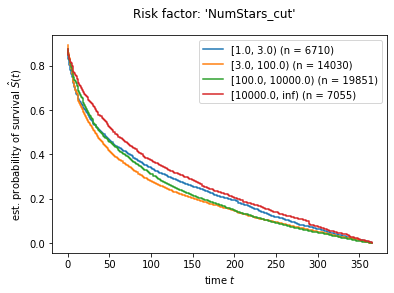

<Figure size 432x288 with 0 Axes>

In [595]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [596]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumStars_cut'>

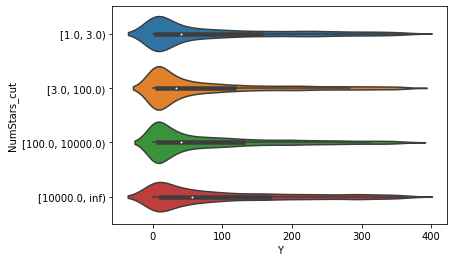

In [597]:
sns.violinplot(data=df, x="Y", y="NumStars_cut")

In [598]:
df_mask = df['NumStars'] < 10000
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

#plot_survival_function(params, ddf, condition_names=values_names)

all = 62866, selected = 40591, uncensored = 40591
Computing 50 × bootstrap Dxy for 40591 elements...


{
    "Cohort": 62866,
    "Number of patients": 40591.0,
    "% of cohort": 64.56749276238348,
    "Survival days, median": 37.0,
    "Survival years, median": 0.10136986301369863,
    "Dxy (full)": 0.007114142400958423,
    "bootstrap": {
        "Dxy": 0.007905122065364084,
        "Confidence interval low": 0.007077021503015951,
        "Confidence interval high": 0.008733222627712218,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
NumStars_cut,,,,,,,,,,,,,
"[1.0, 3.0)",6710,41.0,0,5.0,155.0,365,89.867660,104.342922,1.070487,10.673496,16.530758,16.530758,150.0
"[3.0, 100.0)",14030,33.0,0,6.0,117.0,365,77.743407,96.653150,1.373494,22.317310,34.564312,34.564312,111.0
"[100.0, 10000.0)",19851,40.0,0,7.0,129.0,365,82.462193,95.534515,1.237379,31.576687,48.904930,48.904930,122.0


In [599]:
results_summary[f"{column_cut}+NumStars<10000"] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='NumStars', ylabel='Y'>

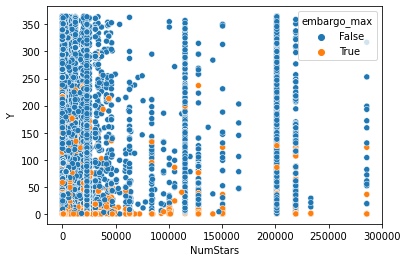

In [600]:
sns.scatterplot(data=df, x='NumStars', y='Y', hue='embargo_max')

-----
**NumForks**

In [601]:
df.columns

Index(['commits', 'commit_cves', 'project_names', 'used_dep_manager',
       'cve_lifespan_commiter_time', 'cve_lifespan_author_time', 'embargo_min',
       'embargo_max', 'lang_Shell', 'other_languages', 'most_common_language',
       'most_common_language_number_of_files', 'programming_paradigm',
       'Programming paradigm', 'compilation_class', 'Compilation class',
       'type_class', 'Type class', 'memory_model', 'Memory model',
       'extended_programming_paradigm', 'Programming paradigm (extended)',
       'cve', 'cvss', 'cwe', 'cvss-vector', 'access.authentication',
       'access.complexity', 'access.vector', 'impact.availability',
       'impact.confidentiality', 'impact.integrity', 'CVSS v2.0 Ratings',
       'CVSS v3.1 Ratings', 'RootFork', 'EarliestCommitDate',
       'LatestCommitDate', 'NumActiveMon', 'NumAuthors', 'NumCore',
       'CommunitySize', 'NumCommits', 'NumBlobs', 'NumFiles', 'NumForks',
       'NumStars', 'E', 'Y', 'NumCore_cut', 'NumCore_cut2', 'NumAuthor

In [602]:
df[['NumForks','NumStars']].describe()

,NumForks,NumStars
count,62859.000000,47646.000000
mean,10552.373709,15912.640327
std,43771.581162,47368.980685
min,0.000000,1.000000
25%,0.000000,5.000000
50%,12.000000,324.000000
75%,827.000000,2902.000000
max,237104.000000,285958.000000


<AxesSubplot: ylabel='Count'>

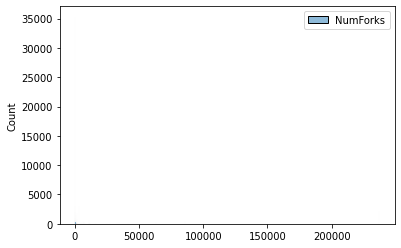

<AxesSubplot: ylabel='Count'>

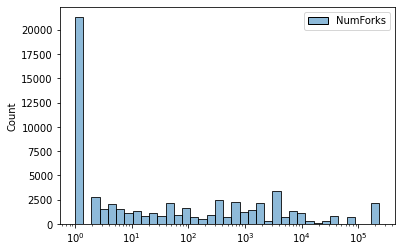

In [603]:
sns.histplot(data=df[['NumForks']].dropna())
plt.show()
sns.histplot(data=df[['NumForks']].dropna()+1, log_scale=True)
plt.show()

/tmp/ipykernel_3832658/2530176179.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumForks_cut
[0.0, 1.0)        21325
[1.0, 5.0)         6378
[5.0, 10.0)        2701
[10.0, 1000.0)    17396
[1000.0, inf)     15059
dtype: int64

CategoricalDtype(categories=[[0.0, 1.0), [1.0, 5.0), [5.0, 10.0), [10.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumForks_cut', ylabel='CVE+project'>

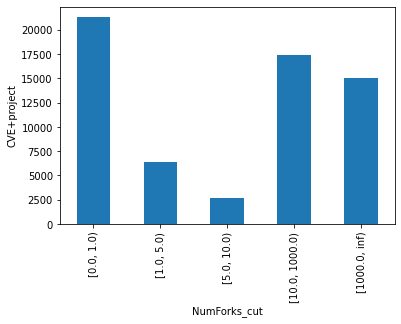

In [604]:
column_name = 'NumForks'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,1,5,10,1e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [605]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(0.0, 1.0, closed='left'),
 1: Interval(1.0, 5.0, closed='left'),
 2: Interval(5.0, 10.0, closed='left'),
 3: Interval(10.0, 1000.0, closed='left'),
 4: Interval(1000.0, inf, closed='left')}

In [606]:
df.columns

Index(['commits', 'commit_cves', 'project_names', 'used_dep_manager',
       'cve_lifespan_commiter_time', 'cve_lifespan_author_time', 'embargo_min',
       'embargo_max', 'lang_Shell', 'other_languages', 'most_common_language',
       'most_common_language_number_of_files', 'programming_paradigm',
       'Programming paradigm', 'compilation_class', 'Compilation class',
       'type_class', 'Type class', 'memory_model', 'Memory model',
       'extended_programming_paradigm', 'Programming paradigm (extended)',
       'cve', 'cvss', 'cwe', 'cvss-vector', 'access.authentication',
       'access.complexity', 'access.vector', 'impact.availability',
       'impact.confidentiality', 'impact.integrity', 'CVSS v2.0 Ratings',
       'CVSS v3.1 Ratings', 'RootFork', 'EarliestCommitDate',
       'LatestCommitDate', 'NumActiveMon', 'NumAuthors', 'NumCore',
       'CommunitySize', 'NumCommits', 'NumBlobs', 'NumFiles', 'NumForks',
       'NumStars', 'E', 'Y', 'NumCore_cut', 'NumCore_cut2', 'NumAuthor

In [607]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62859, uncensored = 62859
Computing 50 × bootstrap Dxy for 62859 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 62866,
    "Number of patients": 62859.0,
    "% of cohort": 99.98886520535743,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.07449118113868725,
    "bootstrap": {
        "Dxy": 0.07368746753404057,
        "Confidence interval low": 0.07289871042229361,
        "Confidence interval high": 0.07447622464578753,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
NumForks_cut,,,,,,,,,,,,,
"[0.0, 1.0)",21325,22.0,0,3.0,98.0,365,67.944431,92.772141,1.560405,33.921357,33.925134,33.925134,95.0
"[1.0, 5.0)",6378,35.0,0,5.0,137.0,365,83.641580,101.069824,1.195537,10.145389,10.146518,10.146518,132.0
"[5.0, 10.0)",2701,59.0,0,9.0,180.0,365,101.888560,106.416104,0.889157,4.296440,4.296919,4.296919,171.0
"[10.0, 1000.0)",17396,33.0,0,6.0,112.0,365,75.088124,92.579305,1.410060,27.671555,27.674637,27.674637,106.0
"[1000.0, inf)",15059,54.0,0,11.0,159.0,365,95.926888,102.650244,1.009096,23.954125,23.956792,23.956792,148.0


In [608]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumForks_cut'>

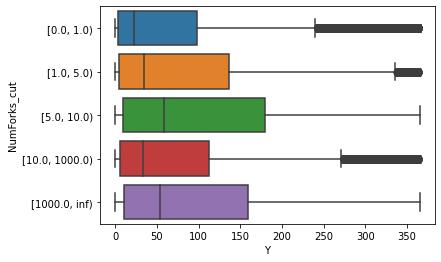

In [609]:
sns.boxplot(data=df, x="Y", y="NumForks_cut")

<AxesSubplot: xlabel='Y', ylabel='NumForks_cut'>

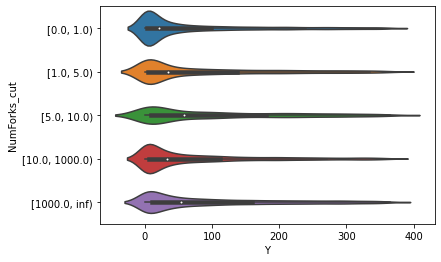

In [610]:
sns.violinplot(data=df, x="Y", y="NumForks_cut")

{0: Interval(0.0, 1.0, closed='left'), 1: Interval(1.0, 5.0, closed='left'), 2: Interval(5.0, 10.0, closed='left'), 3: Interval(10.0, 1000.0, closed='left'), 4: Interval(1000.0, inf, closed='left')}
dict_keys([0, 1, 2, 3, 4])
values_list = dict_keys([0, 1, 2, 3, 4])


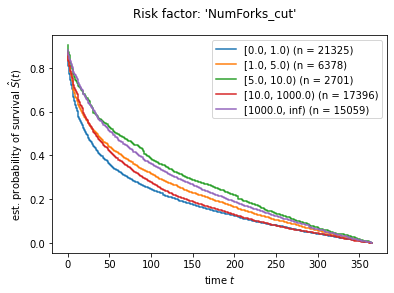

<Figure size 432x288 with 0 Axes>

In [611]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='NumForks', ylabel='Y'>

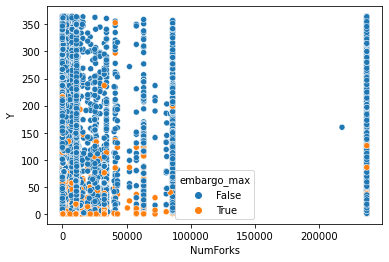

In [612]:
sns.scatterplot(data=df, x='NumForks', y='Y', hue='embargo_max')

----
**CommunitySize** (shared commits?)

In [613]:
df['CommunitySize'].describe()

count     62859.000000
mean       6275.887637
std       22270.800159
min           1.000000
25%           1.000000
50%          16.000000
75%         792.000000
max      154323.000000
Name: CommunitySize, dtype: float64

<AxesSubplot: ylabel='Count'>

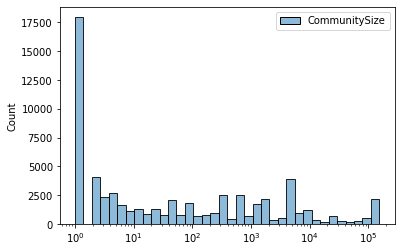

In [614]:
#sns.histplot(data=df[['CommunitySize']].dropna())
#plt.show()
sns.histplot(data=df[['CommunitySize']].dropna(), log_scale=True)
plt.show()

/tmp/ipykernel_3832658/1103352539.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


CommunitySize_cut
[1.0, 2.0)        17977
[2.0, 6.0)         9092
[6.0, 10.0)        2499
[10.0, 1000.0)    17827
[1000.0, inf)     15464
dtype: int64

CategoricalDtype(categories=[[1.0, 2.0), [2.0, 6.0), [6.0, 10.0), [10.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='CommunitySize_cut', ylabel='CVE+project'>

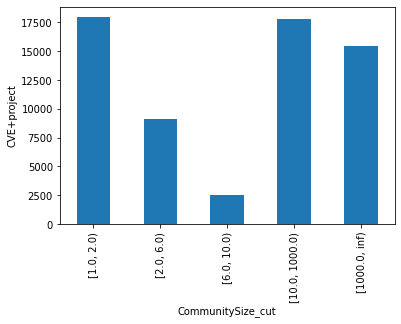

In [615]:
column_name = 'CommunitySize'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,2,6,10,1e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [616]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(1.0, 2.0, closed='left'),
 1: Interval(2.0, 6.0, closed='left'),
 2: Interval(6.0, 10.0, closed='left'),
 3: Interval(10.0, 1000.0, closed='left'),
 4: Interval(1000.0, inf, closed='left')}

In [617]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62859, uncensored = 62859
Computing 50 × bootstrap Dxy for 62859 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 62866,
    "Number of patients": 62859.0,
    "% of cohort": 99.98886520535743,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.06271680733969465,
    "bootstrap": {
        "Dxy": 0.06290395660579184,
        "Confidence interval low": 0.06206797117738462,
        "Confidence interval high": 0.06373994203419907,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
CommunitySize_cut,,,,,,,,,,,,,
"[1.0, 2.0)",17977,23.0,0,4.0,102.0,365,69.528342,94.128766,1.523910,28.595743,28.598928,28.598928,98.0
"[2.0, 6.0)",9092,31.0,0,4.0,125.0,365,79.106687,98.236698,1.288224,14.462508,14.464118,14.464118,121.0
"[6.0, 10.0)",2499,55.0,0,6.0,168.0,365,96.670668,104.783829,0.956454,3.975122,3.975564,3.975564,162.0
"[10.0, 1000.0)",17827,33.0,0,6.0,112.0,365,75.599484,92.727608,1.407174,28.357141,28.360298,28.360298,106.0
"[1000.0, inf)",15464,50.0,0,10.0,156.0,365,93.762093,102.377254,1.037739,24.598352,24.601091,24.601091,146.0


In [618]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

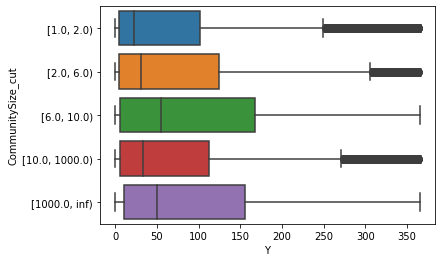

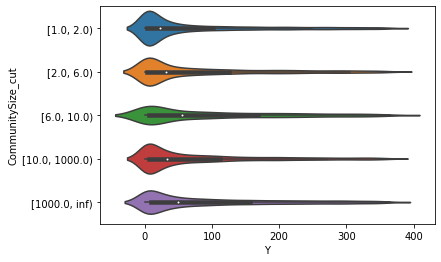

In [619]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

{0: Interval(1.0, 2.0, closed='left'), 1: Interval(2.0, 6.0, closed='left'), 2: Interval(6.0, 10.0, closed='left'), 3: Interval(10.0, 1000.0, closed='left'), 4: Interval(1000.0, inf, closed='left')}
dict_keys([0, 1, 2, 3, 4])
values_list = dict_keys([0, 1, 2, 3, 4])


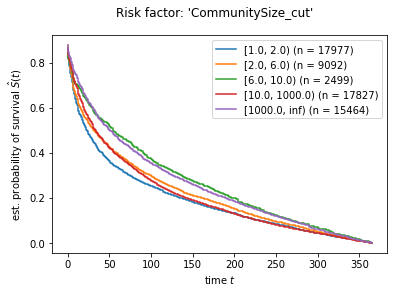

<Figure size 432x288 with 0 Axes>

In [620]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='CommunitySize', ylabel='Y'>

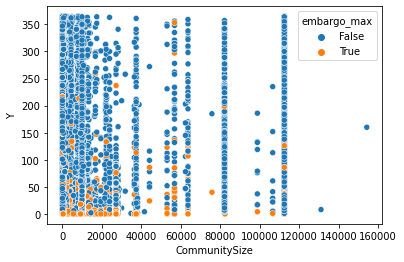

In [621]:
sns.scatterplot(data=df, x='CommunitySize', y='Y', hue='embargo_max')

### NumFiles and NumBlobs

In [622]:
column_name='NumFiles'

In [623]:
df['NumFiles'].describe()

count    6.286600e+04
mean     5.297661e+05
std      1.647684e+06
min      1.000000e+00
25%      1.562250e+03
50%      4.764100e+04
75%      1.982530e+05
max      4.307279e+07
Name: NumFiles, dtype: float64

<AxesSubplot: xlabel='Y'>

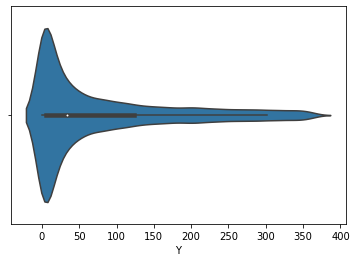

In [624]:
sns.violinplot(data=df[['Y','NumFiles']], x="Y")

<AxesSubplot: ylabel='Count'>

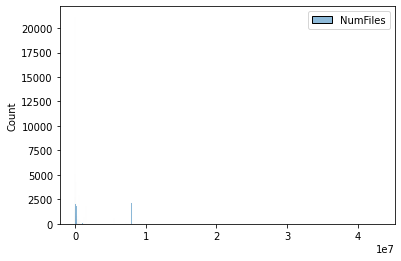

<AxesSubplot: ylabel='Count'>

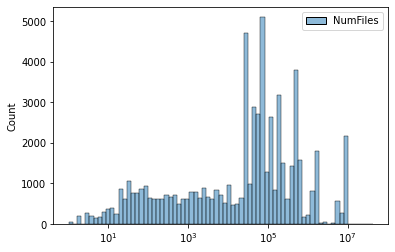

In [625]:
sns.histplot(data=df[[column_name]].dropna())
plt.show()
sns.histplot(data=df[[column_name]].dropna(), log_scale=True)
plt.show()

/tmp/ipykernel_3832658/3357549802.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumFiles_cut
[1.0, 50.0)              5713
[50.0, 1000.0)           8692
[1000.0, 100000.0)      26557
[100000.0, 500000.0)    11051
[500000.0, inf)         10853
dtype: int64

CategoricalDtype(categories=[[1.0, 50.0), [50.0, 1000.0), [1000.0, 100000.0), [100000.0, 500000.0), [500000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumFiles_cut', ylabel='CVE+project'>

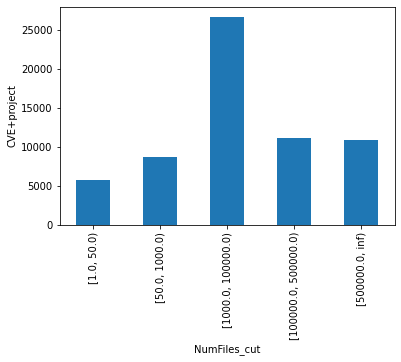

In [626]:
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,50,1e3,1e5,5e5,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [627]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(1.0, 50.0, closed='left'),
 1: Interval(50.0, 1000.0, closed='left'),
 2: Interval(1000.0, 100000.0, closed='left'),
 3: Interval(100000.0, 500000.0, closed='left'),
 4: Interval(500000.0, inf, closed='left')}

In [628]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62866, uncensored = 62866
Computing 50 × bootstrap Dxy for 62866 elements...


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.05756860894540261,
    "bootstrap": {
        "Dxy": 0.057448946260950075,
        "Confidence interval low": 0.05666074139064126,
        "Confidence interval high": 0.05823715113125889,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
NumFiles_cut,,,,,,,,,,,,,
"[1.0, 50.0)",5713,25.0,0,4.0,111.0,365,74.014003,96.872658,1.437662,9.087583,9.087583,9.087583,107.0
"[50.0, 1000.0)",8692,21.0,0,3.0,87.0,365,63.417855,88.988601,1.692396,13.826234,13.826234,13.826234,84.0
"[1000.0, 100000.0)",26557,35.0,0,5.0,135.0,365,82.666830,99.288232,1.213338,42.243820,42.243820,42.243820,130.0
"[100000.0, 500000.0)",11051,31.0,0,6.0,100.0,365,69.184961,87.975987,1.571138,17.578659,17.578659,17.578659,94.0
"[500000.0, inf)",10853,57.0,0,13.0,166.0,365,99.065788,104.270452,0.963760,17.263704,17.263704,17.263704,153.0


In [629]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

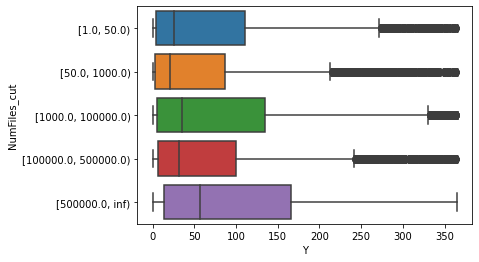

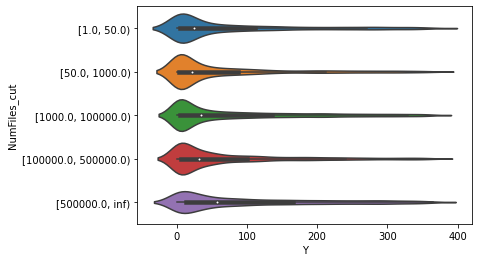

In [630]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2, 3, 4])


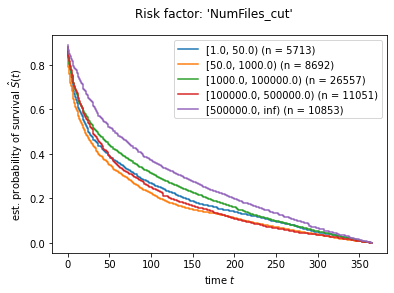

<Figure size 432x288 with 0 Axes>

In [631]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='NumFiles', ylabel='Y'>

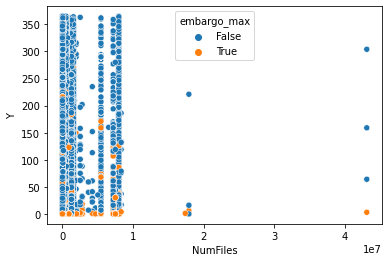

In [632]:
sns.scatterplot(data=df, x=column_name, y='Y', hue='embargo_max')

<AxesSubplot: xlabel='NumFiles', ylabel='Y'>

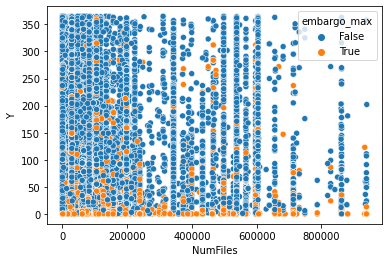

In [633]:
sns.scatterplot(data=df[df['NumFiles']<1e6], x=column_name, y='Y', hue='embargo_max')

----
**NumBlobs**

In [634]:
column_name='NumBlobs'

<AxesSubplot: xlabel='NumFiles', ylabel='NumBlobs'>

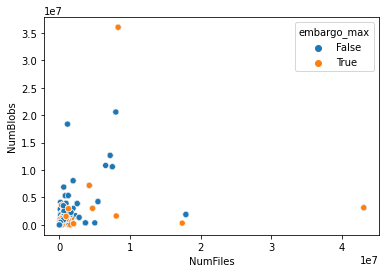

<AxesSubplot: xlabel='NumFiles', ylabel='NumBlobs'>

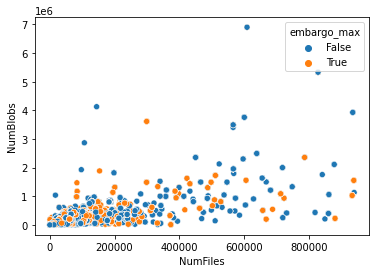

In [635]:
sns.scatterplot(data=df, x='NumFiles', y='NumBlobs', hue='embargo_max')
plt.show()
sns.scatterplot(data=df[df['NumFiles']<1e6], x='NumFiles', y='NumBlobs', hue='embargo_max')
plt.show()

In [636]:
df[['Y','NumFiles','NumBlobs']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62866 entries, 43 to 97745
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Y         62866 non-null  int64
 1   NumFiles  62866 non-null  Int64
 2   NumBlobs  62866 non-null  Int64
dtypes: Int64(2), int64(1)
memory usage: 2.0 MB


<AxesSubplot: ylabel='Count'>

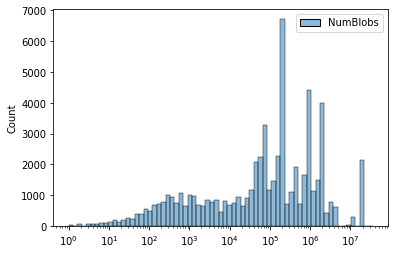

In [637]:
#sns.histplot(data=df[[column_name]].dropna())
#plt.show()
sns.histplot(data=df[[column_name]].dropna(), log_scale=True)
plt.show()

/tmp/ipykernel_3832658/2070229058.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumBlobs_cut
[1.0, 500.0)              8016
[500.0, 10000.0)          9352
[10000.0, 100000.0)      13180
[100000.0, 1000000.0)    18301
[1000000.0, inf)         14017
dtype: int64

CategoricalDtype(categories=[[1.0, 500.0), [500.0, 10000.0), [10000.0, 100000.0), [100000.0, 1000000.0), [1000000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumBlobs_cut', ylabel='CVE+project'>

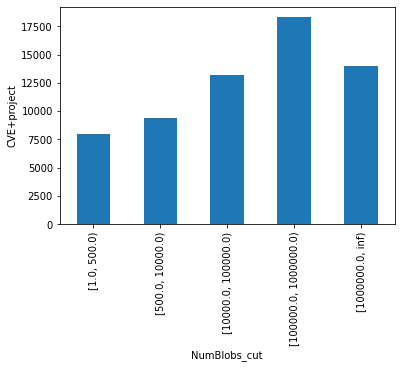

In [638]:
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,5e2,1e4,1e5,1e6,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [639]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(1.0, 500.0, closed='left'),
 1: Interval(500.0, 10000.0, closed='left'),
 2: Interval(10000.0, 100000.0, closed='left'),
 3: Interval(100000.0, 1000000.0, closed='left'),
 4: Interval(1000000.0, inf, closed='left')}

In [640]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62866, uncensored = 62866
Computing 50 × bootstrap Dxy for 62866 elements...


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.021549741535667577,
    "bootstrap": {
        "Dxy": 0.020766861024169053,
        "Confidence interval low": 0.019976211962710468,
        "Confidence interval high": 0.02155751008562764,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
NumBlobs_cut,,,,,,,,,,,,,
"[1.0, 500.0)",8016,25.0,0,5.0,100.0,365,70.364147,93.736842,1.541128,12.750931,12.750931,12.750931,95.0
"[500.0, 10000.0)",9352,28.0,0,3.0,111.0,365,73.322712,94.787163,1.409735,14.876086,14.876086,14.876086,108.0
"[10000.0, 100000.0)",13180,55.5,0,10.0,163.0,365,96.269954,102.390624,0.975335,20.965228,20.965228,20.965228,153.0
"[100000.0, 1000000.0)",18301,25.0,0,4.0,102.0,365,70.397956,94.631550,1.514958,29.111125,29.111125,29.111125,98.0
"[1000000.0, inf)",14017,43.0,0,10.0,135.0,365,85.769637,97.215532,1.197970,22.296631,22.296631,22.296631,125.0


In [641]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

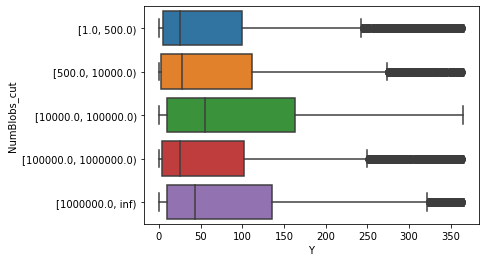

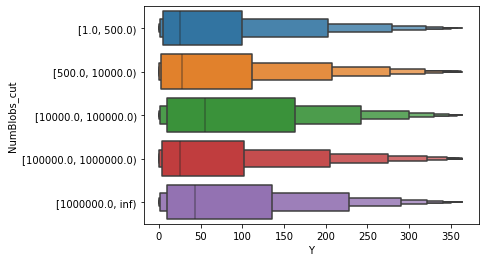

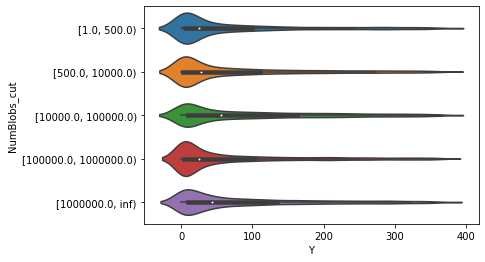

In [642]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2, 3, 4])


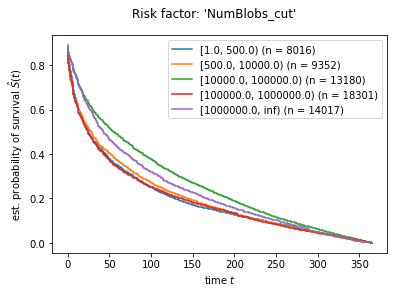

<Figure size 432x288 with 0 Axes>

In [643]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='NumBlobs', ylabel='Y'>

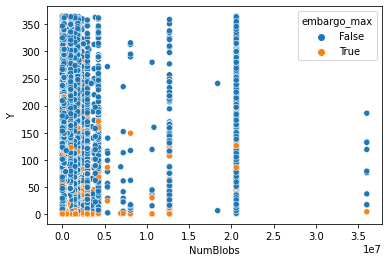

In [644]:
sns.scatterplot(data=df, x=column_name, y='Y', hue='embargo_max')

## Summary

In [645]:
summary_df=pd.DataFrame.from_dict(results_summary, orient='index')
summary_df

,cohort,% of cohort,median,Dxy,Dxy_low,Dxy_high
NumCore_cut,62866,99.915694,34.0,0.085909,0.085299,0.085299
NumAuthors_cut,62866,99.915694,34.0,0.090766,0.089913,0.089913
NumCore/NumAuthors cut,62866,99.915694,34.0,0.052324,0.051827,0.051827
NumCommits_cut,62866,99.829797,34.0,0.001677,0.000944,0.000944
NumCommits_cut2,62866,99.829797,34.0,0.017521,0.016768,0.016768
NumActiveMon [%] cut,62866,99.998409,34.0,-0.104061,-0.104870,-0.104870
NumActiveMon_cut,62866,100.000000,34.0,-0.077359,-0.078051,-0.078051
CommitDateRange [days] cut,62866,100.000000,34.0,0.016896,0.016040,0.016040
NumStars_cut,62866,75.789775,40.0,0.029607,0.028636,0.028636
NumStars_cut+NumStars<10000,62866,64.567493,37.0,0.007905,0.007077,0.007077


<AxesSubplot: title={'center': 'Dxy'}>

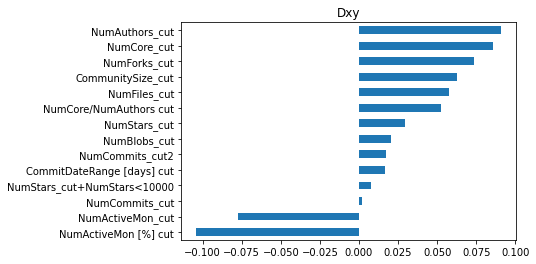

In [646]:
summary_df['Dxy'].sort_values().plot(kind='barh',title='Dxy')

In [647]:
#ver='365days'
ver='most_used_language.365days'
summary_df.to_csv(f"survey_analysis_project_metadata.{ver}.csv")